<a href="https://colab.research.google.com/github/Jacksonfern/trabalho-final-IA/blob/main/Implementa%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-rectified-adam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import keras 
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate
from keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import applications
from keras_radam import RAdam
from sklearn.model_selection import LeaveOneOut, KFold

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers

In [ ]:
seed_value=13

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

In [ ]:
# from google.colab import drive
# drive.mount('https://drive.google.com/drive/folders/1SJWbLqmxnEmjZIDkaRFi88qCeinABjk9?usp=sharing')

In [ ]:
data = pd.read_csv("trains-transformed.csv")

In [ ]:
data.columns

Index(['Number_of_cars', 'Number_of_different_loads', 'num_wheels1', 'length1',
       'shape1', 'num_loads1', 'load_shape1', 'num_wheels2', 'length2',
       'shape2', 'num_loads2', 'load_shape2', 'num_wheels3', 'length3',
       'shape3', 'num_loads3', 'load_shape3', 'num_wheels4', 'length4',
       'shape4', 'num_loads4', 'load_shape4', 'Rectangle_next_to_rectangle',
       'Rectangle_next_to_triangle', 'Rectangle_next_to_hexagon',
       'Rectangle_next_to_circle', 'Triangle_next_to_triangle',
       'Triangle_next_to_hexagon', 'Triangle_next_to_circle',
       'Hexagon_next_to_hexagon', 'Hexagon_next_to_circle',
       'Circle_next_to_circle', 'Class_attribute'],
      dtype='object')

# Question 1.
Implemente uma solução que implemente proposicionalização com 32 neurônios
de entrada e uma única saída (denotando leste). As entradas codificam:


* a quantidade de vagões em um trem
* a quantidade de cargas diferentes em um trem
* a quantidade de eixo com rodas
* o comprimento e a forma de cada vagão
* a quantidade de carga em cada vagão
* as 10 variáveis booleanos descritas acima

## Process data

In [ ]:
def encode_to_int(field,top):
  data[field].replace(top,[float(i) for i in range(len(top)-1)] + [-1] ,inplace=True)

In [ ]:
length = ['short', 'long','None']
shape = ['closedrect', 'dblopnrect', 'ellipse', 'engine', 'hexagon','jaggedtop', 'openrect', 'opentrap', 'slopetop', 'ushaped','None']
load_shape = ['circlelod', 'hexagonlod', 'rectanglod', 'trianglod','None']
Class_attribute = ['west','east']

for f in ['length1','length2','length3','length4']:
  encode_to_int(f,length)

for f in ['shape1','shape2','shape3','shape4']:
  encode_to_int(f,shape)

for f in ['load_shape1','load_shape2','load_shape3','load_shape4']:
  encode_to_int(f,load_shape)

for f in ['num_loads1','num_loads2','num_loads3','num_loads4']:
  encode_to_int(f,['None'])

for f in ['num_wheels1','num_wheels2','num_wheels3','num_wheels4']:
  encode_to_int(f,['None'])


data['Class_attribute'].replace(Class_attribute,[0,1],inplace=True)

In [ ]:
data = data.astype(float)
print(data.dtypes)

Number_of_cars                 float64
Number_of_different_loads      float64
num_wheels1                    float64
length1                        float64
shape1                         float64
num_loads1                     float64
load_shape1                    float64
num_wheels2                    float64
length2                        float64
shape2                         float64
num_loads2                     float64
load_shape2                    float64
num_wheels3                    float64
length3                        float64
shape3                         float64
num_loads3                     float64
load_shape3                    float64
num_wheels4                    float64
length4                        float64
shape4                         float64
num_loads4                     float64
load_shape4                    float64
Rectangle_next_to_rectangle    float64
Rectangle_next_to_triangle     float64
Rectangle_next_to_hexagon      float64
Rectangle_next_to_circle 

### Model used

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
model = keras.models.Sequential()
model.add(tf.keras.layers.Dense(9, input_shape=(32,)))
model.add(keras.layers.Dense(1, activation="sigmoid"))

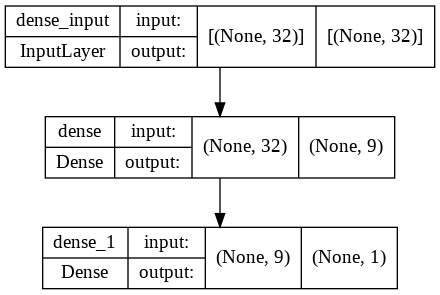

In [ ]:
plot_model(model,show_shapes=True)

In [ ]:
inputs = data.copy(deep=True)

Y = np.array(inputs.pop('Class_attribute'))
X = np.array(inputs)


predicted = []
acc_per_fold = []
loss_per_fold = []

for fold_no in range(10):

  train = list(range(0,10))
  train.remove(fold_no)

  input_train = X[train]
  target_train = Y[train]    

  input_val = X[[fold_no]]
  target_val = Y[[fold_no]]

  model = keras.models.Sequential()
  model.add(tf.keras.layers.Dense(9, input_shape=(32,)))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(keras.layers.Dense(1, activation="sigmoid"))

  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),loss = tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(input_train, target_train,
              epochs=100,
              verbose=0,
              validation_data=(input_val,target_val))

  # Generate generalization metrics
  scores = model.evaluate(input_val, target_val, verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  predicted.append(model.predict(input_val)[0][0])

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 0 ...
Score for fold 0: loss of 3.93275785446167; accuracy of 0.0%
------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.34516435861587524; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.04814023897051811; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.1543305516242981; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.13434454798698425; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.3090142607688904; accuracy of 100.0%
-----------------------------

In [ ]:
df = pd.DataFrame()
df['train'] = np.array(list(range(10)))
df['Output Flat Network'] = predicted
df['Discrete output'] = df['Output Flat Network'].apply(lambda x: 1 if x > 0.5 else 0)
df['Desired Output'] = Y

In [ ]:
df

,train,Output Flat Network,Discrete output,Desired Output
0,0,0.019590,0,1.0
1,1,0.708104,1,1.0
2,2,0.953000,1,1.0
3,3,0.856989,1,1.0
4,4,0.874289,1,1.0
5,5,0.265830,0,0.0
6,6,0.413709,0,0.0
7,7,0.076639,0,0.0
8,8,0.995672,1,0.0
9,9,0.782542,1,0.0


Questão 2. Implemente uma solução com base no modelo de aprendizado
relacional contendo meta-redes para conectar conceitos das premissas. Este
modelos deve conter 11 redes, uma para cada um dos seguintes conceitos
conforme definição das paginas 136 e 137:


In [ ]:
# Valores de atributos como entrada da rede
def  metarede():
    t   = Input(shape=(1,), name='t')
    c   = Input(shape=(1,), name='c') 
    w   = Input(shape=(1,), name='w')
    l   = Input(shape=(1,), name='l')
    s   = Input(shape=(1,), name='s')
    nc  = Input(shape=(1,), name='nc')
    ls  = Input(shape=(1,), name='ls')
    nl  = Input(shape=(1,), name='nl')
    ncl = Input(shape=(1,), name='ncl')
    x_crc = Input(shape=(1,), name='x_crc')
    x_hex = Input(shape=(1,), name='x_hex')
    x_rec = Input(shape=(1,), name='x_rec')
    x_tri = Input(shape=(1,), name='x_tri')
    
    # 1. num_cars(t, nc), em que t ∊ [1..10] e nc ∊ [3..5].
    num_cars_ = concatenate([t,nc])
    num_cars_ = Dense(20, activation='relu')(num_cars_)
    num_cars = Dense(1, activation='sigmoid', name='num_cars')(num_cars_)
    num_cars = Model(inputs=[t,nc], outputs=num_cars)
    
    #2. num\_loads(t, nl) em que t ∊ [1..10] e nl ∊ [1..4].
    num_loads_ = concatenate([t,nl])
    num_loads_ = Dense(20, activation='relu')(num_loads_)
    num_loads = Dense(1, activation='sigmoid', name='num_loads')(num_loads_)
    num_loads = Model(inputs=[t,nl], outputs=num_loads)
    
    #3. num_wheels(t, c, w) em que t ∊ [1..10] e c ∊ [1..4] e w ∊ [2..3].
    num_wheels_ = concatenate([t,c,w])
    num_wheels_ = Dense(20, activation='relu')(num_wheels_)
    num_wheels = Dense(1, activation='sigmoid', name='num_wheels')(num_wheels_)
    num_wheels = Model(inputs=[t,c,w], outputs=num_wheels)
    
   #4. length(t, c, l) em que t ∊ [1..10] e c ∊ [1..4] e l ∊ [-1..1](-1 denota curto e 1 longo)
    length_ = concatenate([t,c,l])
    length_ = Dense(20, activation='relu')(length_)
    length = Dense(1, activation='sigmoid', name='length')(length_)
    length = Model(inputs=[t,c,l], outputs=length)
    
    #5.shape(t, c, s) em que t ∊ [1..10] e c ∊ [1..4] e s ∊ [1..10](um número para cada forma).
    shape_ = concatenate([t,c,s])
    shape_ = Dense(20, activation='relu')(shape_)
    shape = Dense(1, activation='sigmoid', name='shape')(shape_)
    shape = Model(inputs=[t,c,s], outputs=shape)
    
    #6. num_cars_loads(t, c, ncl) em que t ∊ [1..10] e c ∊ [1..4] e ncl ∊ [0..3].
    num_car_loads_ = concatenate([t,c,ncl])
    num_car_loads_ = Dense(20, activation='relu')(num_car_loads_)
    num_car_loads = Dense(1, activation='sigmoid', name='num_car_loads')(num_car_loads_)
    num_car_loads = Model(inputs=[t,c,ncl], outputs=num_car_loads)
    
    #7. load_shape(t, c, ls) em que t ∊ [1..10] e c ∊ [1..4] e ls ∊ [1..4].
    load_shape_ = concatenate([t,c,ls])
    load_shape_ = Dense(20, activation='relu')(load_shape_)
    load_shape = Dense(1, activation='sigmoid', name='load_shape')(load_shape_)
    load_shape = Model(inputs=[t,c,ls], outputs=load_shape)
    
    #8. next_crc(t, c, x) em que t ∊ [1..10] e c ∊ [1..4] e x ∊ [-1..1], em que o vagão c do trem t tem um vagão adjacente com cargas em círculo.
    next_crc_ = concatenate([t,c,x_crc])
    next_crc_ = Dense(20, activation='relu')(next_crc_)
    next_crc = Dense(1, activation='sigmoid', name='next_crc')(next_crc_)
    next_crc = Model(inputs=[t,c,x_crc], outputs=next_crc)
    
    #9. next_hex(t, c, x) em que t ∊ [1..10] e c ∊ [1..4] e x ∊ [-1..1], em que o vagão c do trem t tem um vagão adjacente com cargas em hexágono.
    next_hex_ = concatenate([t,c,x_hex])
    next_hex_ = Dense(20, activation='relu')(next_hex_)
    next_hex = Dense(1, activation='sigmoid', name='next_hex')(next_hex_)
    next_hex = Model(inputs=[t,c,x_hex], outputs=next_hex)
    
    #10. next_rec(t, c, x) em que t ∊ [1..10] e c ∊ [1..4] e x ∊ [-1..1], em que o vagão c do trem t tem um vagão adjacente com cargas em retângulo.
    next_rec_ = concatenate([t,c,x_rec])
    next_rec_ = Dense(20, activation='relu')(next_rec_)
    next_rec = Dense(1, activation='sigmoid', name='next_rec')(next_rec_)
    next_rec = Model(inputs=[t,c,x_rec], outputs=next_rec)
    
    #11.next_tri(t, c, x) em que t ∊ [1..10] e c ∊ [1..4] e x ∊ [-1..1], em que o vagão c do trem t tem um vagão adjacente com cargas em triângulo
    next_tri_ = concatenate([t,c,x_tri])
    next_tri_ = Dense(20, activation='relu')(next_tri_)
    next_tri = Dense(1, activation='sigmoid', name='next_tri')(next_tri_)
    next_tri = Model(inputs=[t,c,x_tri], outputs=next_tri)
    
    east = concatenate([ num_cars_, num_loads_, num_wheels_,length_,shape_, num_car_loads_,
                    load_shape_, next_crc_, next_hex_, next_rec_,next_tri_])
    east = Dense(3, activation='relu')(east)
    east =  Dense(1, activation='sigmoid', name='east')(east)
    east = Model(inputs=[t, c, w, l, s, nc, ls, nl, ncl, x_crc, x_hex, x_rec, x_tri], outputs=east)
    
    # metanet
    metanet = Model(inputs=east.inputs, 
                outputs=[num_cars.output, num_loads.output, num_wheels.output, length.output,
                         shape.output, num_car_loads.output, load_shape.output,next_crc.output,
                         next_hex.output, next_rec.output, next_tri.output, east.output])
    
    rules = { 'num_cars': num_cars, 'num_loads': num_loads, 'num_wheels': num_wheels, 
          'length': length, 'shape': shape, 'num_car_loads': num_car_loads,
          'load_shape': load_shape, 'next_crc': next_crc, 'next_hex': next_hex,
          'next_rec': next_rec, 'next_tri': next_tri,}
    return metanet, east, rules

metanet, east, rules =  metarede()

    

In [ ]:
metanet.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 t (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 nc (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 nl (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 c (InputLayer)                 [(None, 1)]          0           []                               
                                                                                           

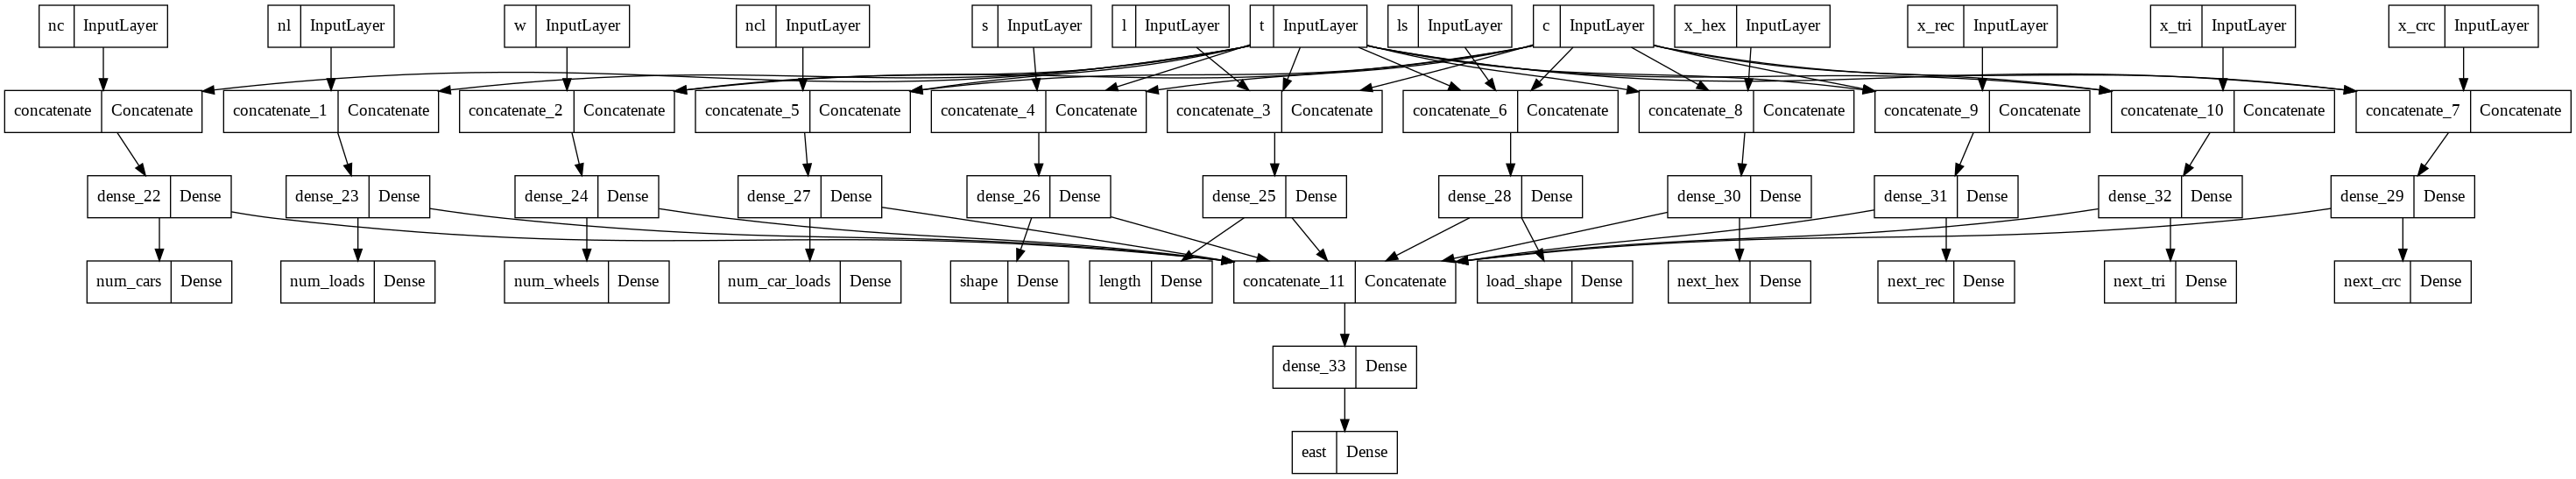

In [ ]:
plot_model(metanet, show_shapes=False, show_layer_names=True)

In [ ]:
# transform data
df = data
cols = [[c for c in df.columns if not(str.isdigit(c[-1])) or (str.isdigit(c[-1]) and int(c[-1])==n)] for n in range(1,5)]

dt = [df[col] for col in cols]
for c, df in enumerate(dt):
    df.columns = [name if not str.isdigit(name[-1]) else name[:-1] for name in df.columns]
    df['car'] = c+1

dt = pd.concat(dt)
dt.reset_index(level=0, inplace=True)
dt['train'] = dt.pop('index')
dt.T[0]

Number_of_cars                 5.0
Number_of_different_loads      4.0
num_wheels                     2.0
length                         1.0
shape                          6.0
num_loads                      3.0
load_shape                     2.0
Rectangle_next_to_rectangle    0.0
Rectangle_next_to_triangle     1.0
Rectangle_next_to_hexagon      0.0
Rectangle_next_to_circle       0.0
Triangle_next_to_triangle      0.0
Triangle_next_to_hexagon       1.0
Triangle_next_to_circle        0.0
Hexagon_next_to_hexagon        0.0
Hexagon_next_to_circle         1.0
Circle_next_to_circle          0.0
Class_attribute                1.0
car                            1.0
train                          0.0
Name: 0, dtype: float64

In [ ]:
def get_att(X):
    t = X['train'].T
    c = X['car'].T
    w = X['num_wheels'].T
    l = X['length'].T
    s = X['shape'].T
    nc = X['Number_of_cars'].T
    ls = X['load_shape'].T
    nl = X['Number_of_different_loads'].T
    ncl = X['num_loads'].T
    x_crc = np.sum(X[[col for col in X if col.endswith('circle')]], axis=1).T
    x_hex = np.sum(X[[col for col in X if col.endswith('hexagon')]], axis=1).T
    x_rec = np.sum(X[[col for col in X if col.endswith('rectangle')]], axis=1).T
    x_tri = np.sum(X[[col for col in X if col.endswith('triangle')]], axis=1).T
    return [t, c, w, l, s, nc, ls, nl, ncl, x_crc, x_hex, x_rec, x_tri]

In [ ]:
def split(data, val_train):
    x_train = data.query(f'train != {val_train}')
    x_test = data.query(f'train == {val_train}')
    y_train = np.array(x_train.pop('Class_attribute'))
    y_test = np.array(x_test.pop('Class_attribute'))
    x_train = get_att(x_train)
    x_test = get_att(x_test)
    return x_train, x_test, np.array(y_train), np.array(y_test)

In [ ]:
kf = KFold(n_splits=10, shuffle=False)
hists = dict()
q2_names =  [
  'Train',
  'Cars Accuracy',
  'Output of flat network', 
  'Desired output', 
  'Class'
]
q2 = {name: [] for name in q2_names}

for val_train in range(0,10):
    x_train, x_test, y_train, y_test = split(dt, val_train)
    metanet, east, rules = metarede()

    east.compile(
      loss = binary_crossentropy, 
      optimizer = RAdam(learning_rate=0.01),
      metrics = ['mse', 'binary_accuracy'])
    hist = east.fit(
      x_train,
      y_train,
      validation_data=[x_test, y_test],
      epochs=500,
      verbose=0,
      )
    hists[val_train] = hist

    q2['Train'].append(val_train)
    q2['Output of flat network'].append(east.predict(x_test)[0][0])
    q2['Desired output'].append(y_test[0])
    q2['Class'].append(Class_attribute[int(y_test[0])])

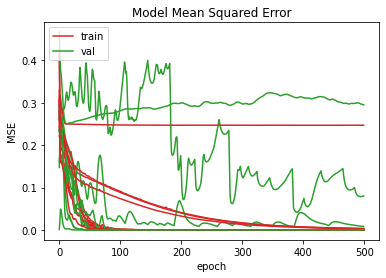

In [ ]:
for i,history in enumerate(hists.values()):
    plt.plot(history.history['mse'], c='tab:red')
    plt.plot(history.history['val_mse'], c='tab:green')

plt.title('Model Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

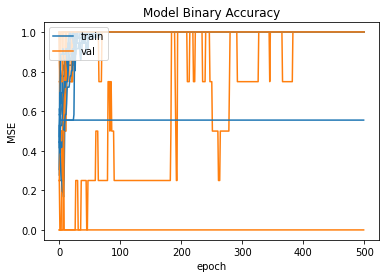

In [ ]:
for i,history in enumerate(hists.values()):
    plt.plot(history.history['binary_accuracy'], c='tab:blue')
    plt.plot(history.history['val_binary_accuracy'], c='tab:orange')

plt.title('Model Binary Accuracy')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
q2['Cars Accuracy'] = [hists[i].history['binary_accuracy'][-1] for i in range(0,10)]

t2 = pd.DataFrame.from_dict(q2).round(2)
t2['Cars Accuracy'] = [hists[i].history['binary_accuracy'][-1] for i in range(0,10)]
t2 = t2.reindex(columns=['Train', 'Cars Accuracy', 'Output of flat network', 'Desired output', 'Class'])
t2

,Train,Cars Accuracy,Output of flat network,Desired output,Class
0,0,1.000000,1.00,1.0,east
1,1,1.000000,1.00,1.0,east
2,2,1.000000,1.00,1.0,east
3,3,1.000000,1.00,1.0,east
4,4,1.000000,0.83,1.0,east
5,5,1.000000,0.37,0.0,west
6,6,1.000000,0.00,0.0,west
7,7,0.555556,0.54,0.0,west
8,8,1.000000,0.00,0.0,west
9,9,1.000000,0.00,0.0,west
